# Exercise 06: PCA & Latent Semantic Analysis

In this exercise we will implement
- PCA using eigendecompositions and using SVD on the appropriate matrices and
- Latent Semantic Analysis

You must implement all required functionality using standard numpy functions for linear algebra operations (do not use the statistical functions like cov and mean etc. for example).
For LSA we will make an exception and use some ready-made functions from scikit-learn.


In [28]:
import numpy as np
import matplotlib.pyplot as plt

## PCA

In [ ]:
# Load MNIST dataset containing
# - 70,000 samples of hand-written digits (28x28 pixel values)

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target
print(X.shape)


/Users/tomsanchez/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


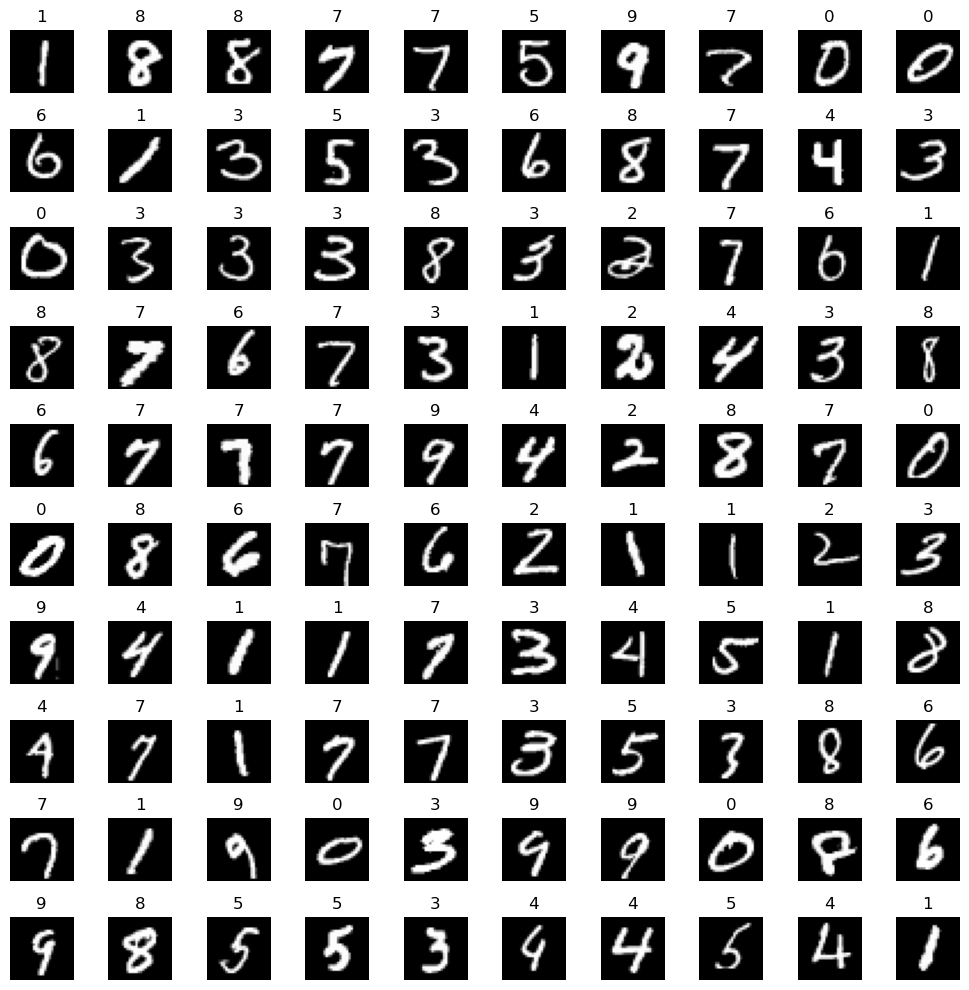

In [30]:
# Visualize random 100 samples
random_indices = np.random.choice(X.shape[0], 100, replace=False)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X.iloc[random_indices[i]].values.reshape(28, 28), cmap='gray')
    ax.set_title(f"{y.iloc[random_indices[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [41]:
# center data of n x m matrix X, where n is number of samples and m number of features
def center_data(X):
    X = np.array(X)
    M = X.shape[1]
    N = X.shape[0]
    # mean_vector = np.zeros((M,))
    means = np.sum(X, axis=0) / N

    # for i in range(M):
    #     sum = 0
    #     for j in range(N):
    #         sum += X[j,i]
    #     mean = sum/N
    #     mean_vector[i] = mean
    X = X - means
    return X


In [42]:
# compute covariance matrix of n x m matrix X
def covariance_matrix(X):
    N = X.shape[0]
    M = X.shape[1]
    cov = 1/(N-1) * (X.T@X)
    return cov

In [43]:
# given n x m matrix X, where n is number of samples and m number of features, compute PCA
def PCA(X, n_components):
    M = center_data(X)
    S = covariance_matrix(M)
    L, Q = np.linalg.eigh(S)

    sorted_indices = np.argsort(L)[::-1]
    L = L[sorted_indices]
    Q = Q[:, sorted_indices]

    Q_reduced = Q[:, :n_components]
    X_pca = M @ Q_reduced 

    return X_pca
    # return PCA matrix


In [44]:
def PCA_via_SVD(X, n_components):
    M = center_data(X)
    U, S, Vt = np.linalg.svd(M, full_matrices=False) # economical svd for computational purposes
    Q = Vt.T
    Q_reduced = Q[:, :n_components]
    X_pca = M @ Q_reduced
    return X_pca
    # return PCA matrix
    

In [45]:
X_pca_svd = PCA_via_SVD(X, 2)
X_pca = PCA(X, 2)

In [47]:
# Visualize the first two principal components
def visualize_2d(X, y):
    y = y.astype(int)

    # Plot the first two principal components
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter, ticks=range(10), label='Digit Label')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of MNIST Dataset')
    plt.show()

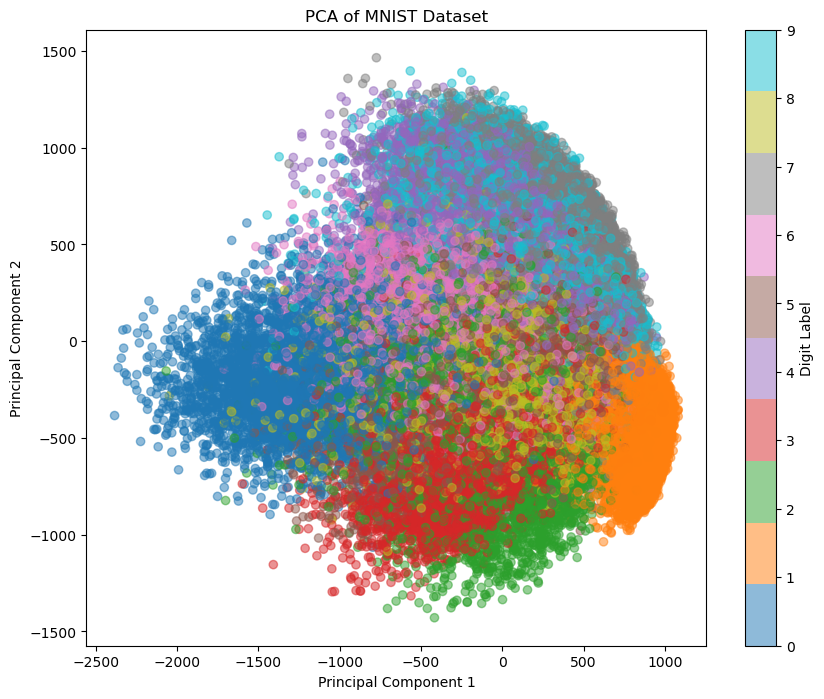

In [48]:
visualize_2d(X_pca, y)

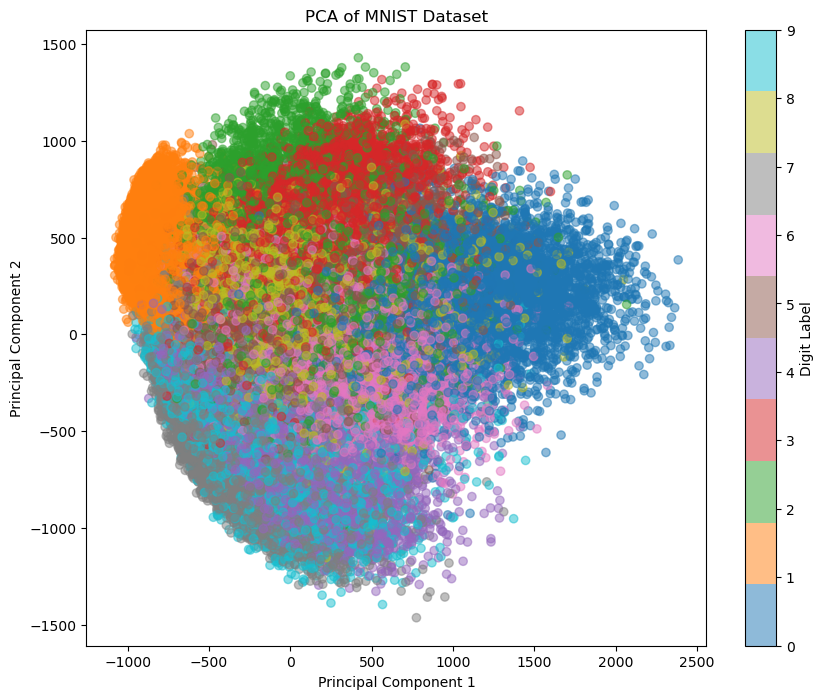

In [49]:
visualize_2d(X_pca_svd, y)

## Latent Semantic Analysis

In [81]:
from sklearn.datasets import fetch_20newsgroups
import re
from collections import defaultdict
from typing import List
from math import log

categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))

In [82]:
# We will use pre-made tokenizer and word count functionality from sklearn
# TF = term frequency
# IDF = inverse document frequency
# TFIDF = TF * IDF <- normalized term frequency
# We use sklearn to this end.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
TFIDF = vectorizer.fit_transform(newsgroups.data)
vectorizer_tf = TfidfVectorizer(use_idf=False)
TF = vectorizer_tf.fit_transform(newsgroups.data)
print(TFIDF.shape) # 2034 documents, 26879 words in total

(2034, 26879)


In [83]:
from sklearn.decomposition import TruncatedSVD
n_components = 16  # Number of components to keep
svd = TruncatedSVD(n_components=n_components)
# Perform SVD on the TFIDF matrix
TFIDF_transformed = np.array(svd.fit_transform(TFIDF))
V = svd.components_
print(TFIDF_transformed.shape)
print(V.shape)


(2034, 16)
(16, 26879)


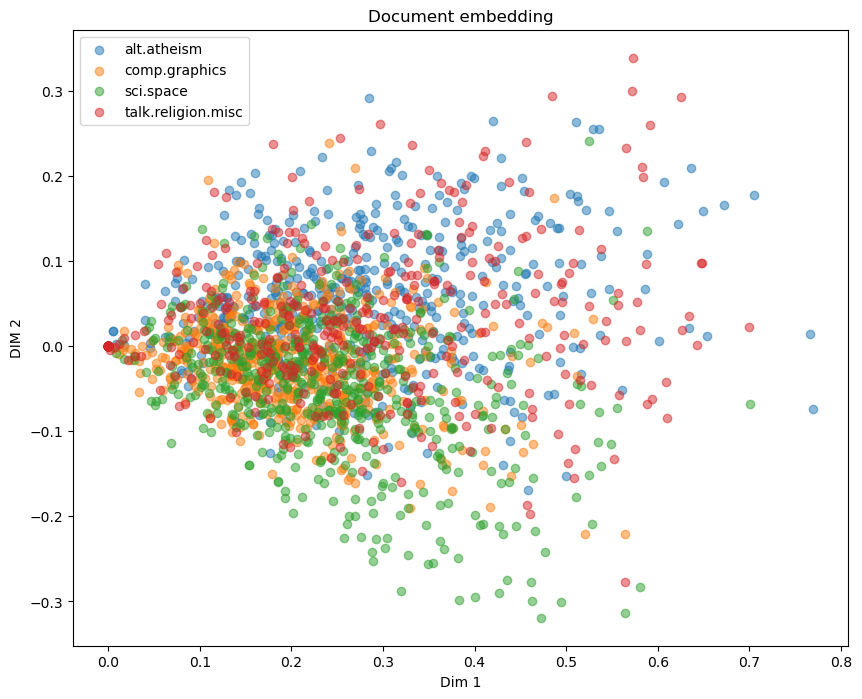

In [84]:
# Evaluate document similarity in the reduced space
def visualize_docs(docs_rep, docs_categories, categories):
    docs_categories = docs_categories.astype(int)

    # Plot the first two principal components
    plt.figure(figsize=(10, 8))
    for i in range(len(categories)):
        mask = docs_categories == i
        plt.scatter(docs_rep[mask, 0], docs_rep[mask, 1], label=categories[i], alpha=0.5)
    plt.legend()
    plt.xlabel('Dim 1')
    plt.ylabel('DIM 2')
    plt.title('Document embedding')
    plt.show()

visualize_docs(TFIDF_transformed, newsgroups.target, categories)

In [85]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

# Print the most important words for each topic
# For each of the 16 topics that we have, search for the 10 words such that their values in V are the largest
# print out the words
def print_topics(V, vocab):
    k = V.shape[0]
    for i in range(k):
        print(f"Topic {i}:")
        topic_weights = V[i]  
        top_word_indices = np.argsort(np.abs(topic_weights))[::-1]
        top_words = [vocab[j] for j in top_word_indices[:10]]
        for word in top_words:
            print(word, end=" ")
        print("\n")

    pass
print_topics(V, vocab)

Topic 0:
the to of and is that it in you for 

Topic 1:
the you that space your of it god not do 

Topic 2:
the for thanks graphics of any that god he files 

Topic 3:
is you they space was objective ico beauchaine bronx bobbe 

Topic 4:
you he space was they it that your of are 

Topic 5:
it god space of you be was to the would 

Topic 6:
he is they was ico bobbe tek manhattan bronx beauchaine 

Topic 7:
the and space it god you to of be was 

Topic 8:
of to this god was graphics the do be objective 

Topic 9:
it he is space to of we god they nasa 

Topic 10:
and it that thanks the graphics be would as any 

Topic 11:
do be and space he what this anyone they in 

Topic 12:
to he is it god this of that cview was 

Topic 13:
of it objective was and are they what to that 

Topic 14:
of that as is for to if objective morality do 

Topic 15:
we do be graphics would who this for me was 



In [106]:
# Do document retrievel
# Given a list of query words, look up their representation via their entries in matrix V and sum up all representations into a query vector
# normalize the query vector to have unit length
# multiply with TFIDF_transformed and sort the results in descending order
# print out the top 5 documents

def retrieve(terms, vocab, V, TFIDF_transformed, docs):
    query_vector = np.zeros((V.shape[0]))

    for term in terms:
        query_index = np.where(vocab == term)[0][0]
        query_vector += V.T[query_index]

    normalized_query_vector = query_vector/np.linalg.norm(query_vector)
    query = normalized_query_vector@TFIDF_transformed.T
    sorted_query = np.argsort(np.abs(query))[::-1]
    for i in sorted_query:
        print(docs[i])
    pass # Fill in here

In [ ]:
retrieve(['jesus'], vocab, V, TFIDF_transformed, newsgroups.data)

: I will clarify my earlier quote.  God's laws were originally written for 
: the Israelites.  Jesus changed that fact by now making the Law applicable to
: all people, not just the Jews.  Gentiles could be part of the kingdom of
: Heaven through the saving grace of God.  I never said that the Law was made
: obsolete by Jesus.

Just for reference, here's the earlier quote:
Malcolm Lee (mlee@post.RoyalRoads.ca) wrote in reference to Leviticus 21:9
and Deuteronomy 22:20-25:
: These laws written for the Israelites, God's chosen people whom God had
: expressly set apart from the rest of the world.  The Israelites were a
: direct witness to God's existence.  To disobey God after KNOWing that God
: is real would be an outright denial of God and therefore immediately
: punishable.
: Remember, these laws were written for a different time and applied only to
: God's chosen people.  But Jesus has changed all of that.  We are living in
: the age of grace.  Sin is no longer immediately punishable 

In [ ]:
retrieve(['war'], vocab, V, TFIDF_transformed, newsgroups.data)

I told some friends of mine two weeks ago that Koresh was dead.  The FBI and
the BATF could not let a man like that live.  He was a testimonial to their
stupidity and lies.    

Now before everyone gets crazy with me, let me say that Koresh was crazy as 
a bed bug, but out government was crazier...and they lied to us.

They told us compound had been under survaillance for quite some time.  Yet, 
whoever was watching the place failed to see that Koresh went jogging and into
town on a regular basis.  Everyone in the area claimed to have seen him and 
wondered why they didn't pick him up then.  There are two possible answers.
First, they didn't see him.  What kind of survaillance is that?  Second, they
didn't care.  They wanted a confrontation.  They wanted publicity and they got
it.

After the first battle, they told us that they did not know he knew they were
coming.  They also said it would have been foolish to go in knowing that.
Well, we know now that they intercepted the informants 

In [105]:
retrieve(['crazy'], vocab, V, TFIDF_transformed, newsgroups.data)

: 
:   Nut or not, he was clearly a liar.  He said he would surrender after
:   local radio stations broadcast his message, but he didn't.  Then he
:   said he would surrender after Passover, but he didn't.
: 


I _know_ I shouldn't get involved, but...   :-)

[bit deleted]


Righto, DAN, try this one with your Cornflakes...

The book says that Muhammad was either a liar, or he was crazy ( a 
modern day Mad Mahdi) or he was actually who he said he was.
Some reasons why he wouldn't be a liar are as follows.  Who would 
die for a lie?  Wouldn't people be able to tell if he was a liar?  People 
gathered around him and kept doing it, many gathered from hearing or seeing 
how his son-in-law made the sun stand still.  Call me a fool, but I believe 
he did make the sun stand still.  
Niether was he a lunatic.  Would more than an entire nation be drawn 
to someone who was crazy.  Very doubtful, in fact rediculous.  For example 
anyone who is drawn to the Mad Mahdi is obviously a fool, logical 